In [1]:
import seaborn as sns

from motifs.pipeline import Pipeline
from motifs.plots import plot_motif_histogram, plot_tf_idf
from motifs.pca import pca_transform

# corpus_path = PKG_DATA_PATH.joinpath('corpus_test')

tokens_dir = "../demo/20231027_115357_pipeline_corpus_test/tokens" # "demo/20231025_162248_pipeline/tokens"
token_type = "motif"
feature = {"name": "tfidf"}
n = 4
pipeline = Pipeline("motif", feature, n, tokens_dir=tokens_dir, save=False)

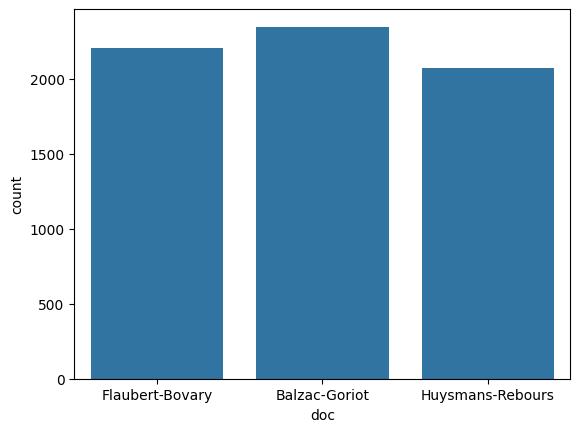

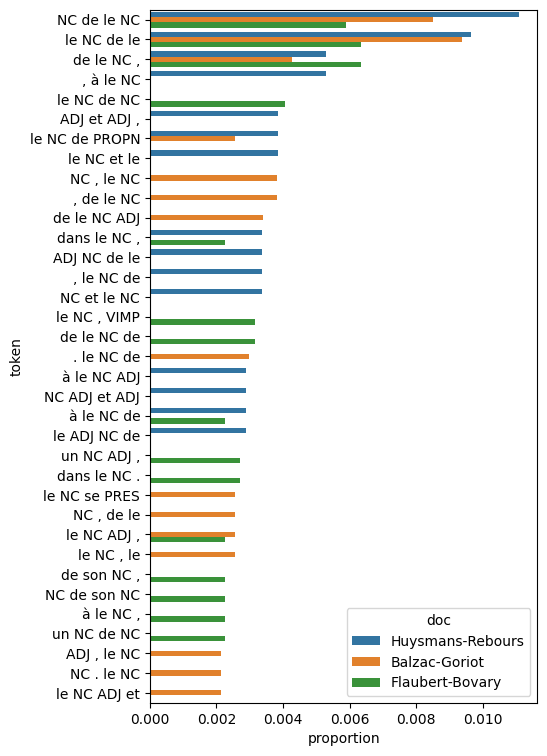

In [2]:
# Transform to n_grams
pipeline.transform_to_ngrams()
## Plot the count of tokens for each document within the corpus
sns.countplot(pipeline.ngrams, x="doc")
# Plot distribution of tokens
plot_motif_histogram(pipeline.ngrams, stat="proportion", n_tokens=15, plot_type="group")

/Users/brunospilak/miniconda3/envs/pymotifs/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


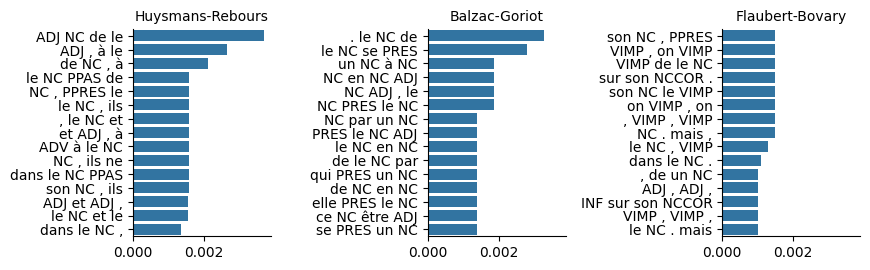

In [3]:
# Compute features, for example tfidf
features_data = pipeline.get_features()
plot_tf_idf(features_data, n_tokens=15, plot_type="sep")

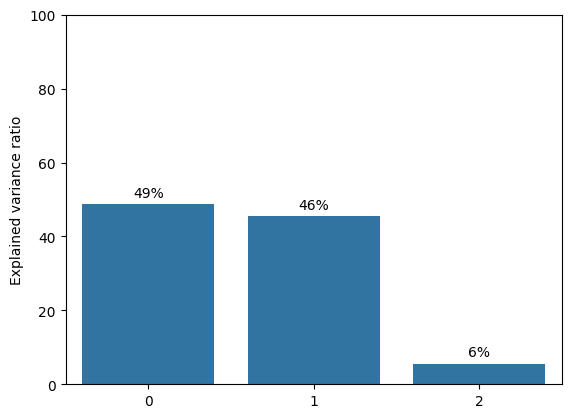

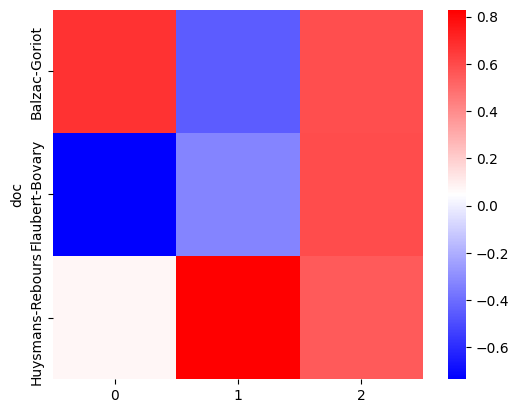

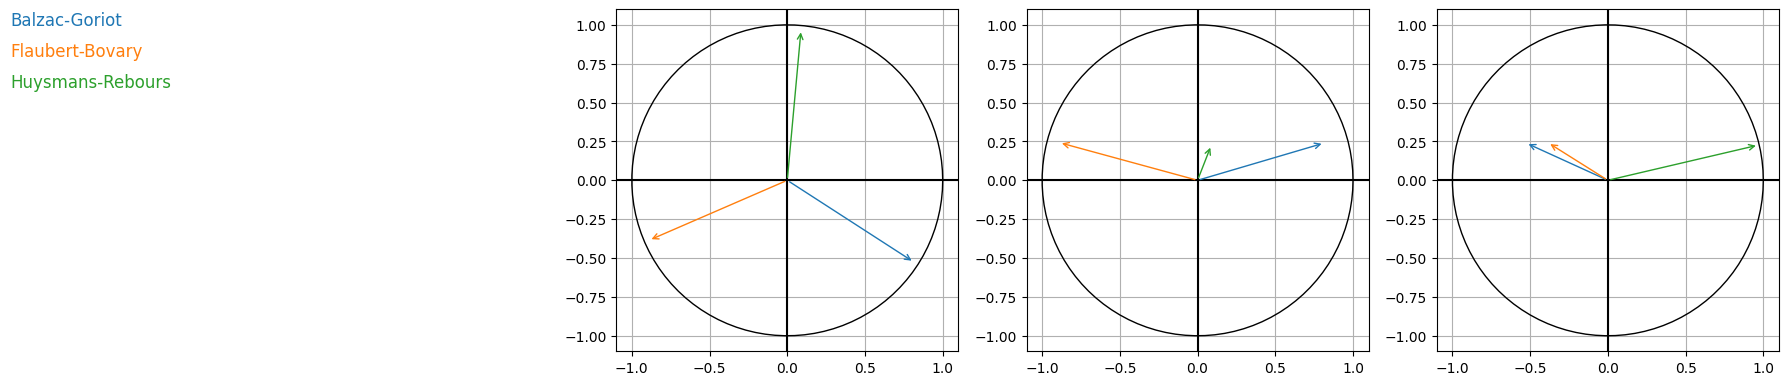

In [4]:
# PCA
pca = pca_transform(
    features_data.pivot_table(
        index="token", columns=["doc"], values=feature["name"]
    ), 
    plot=True
)

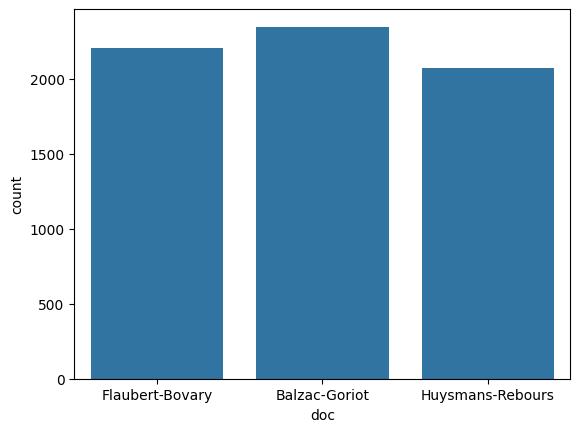

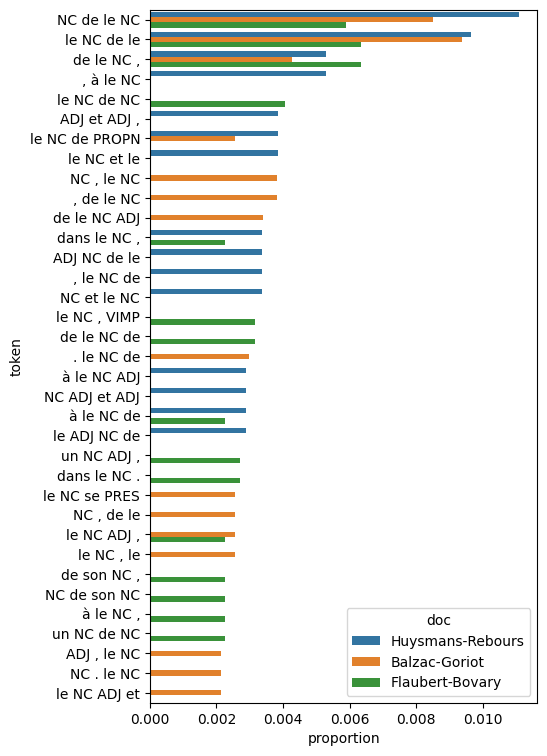

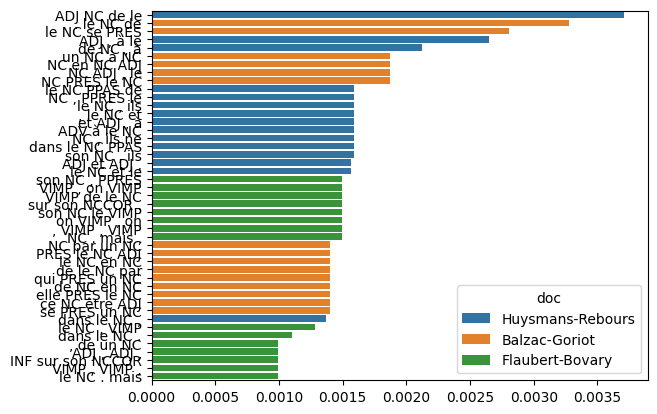

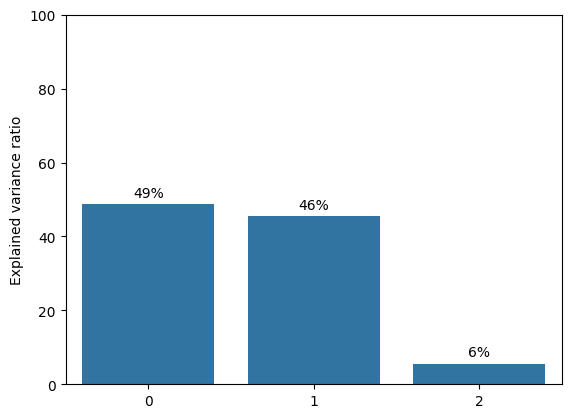

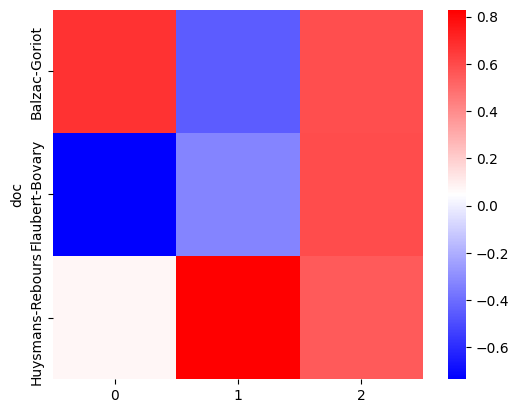

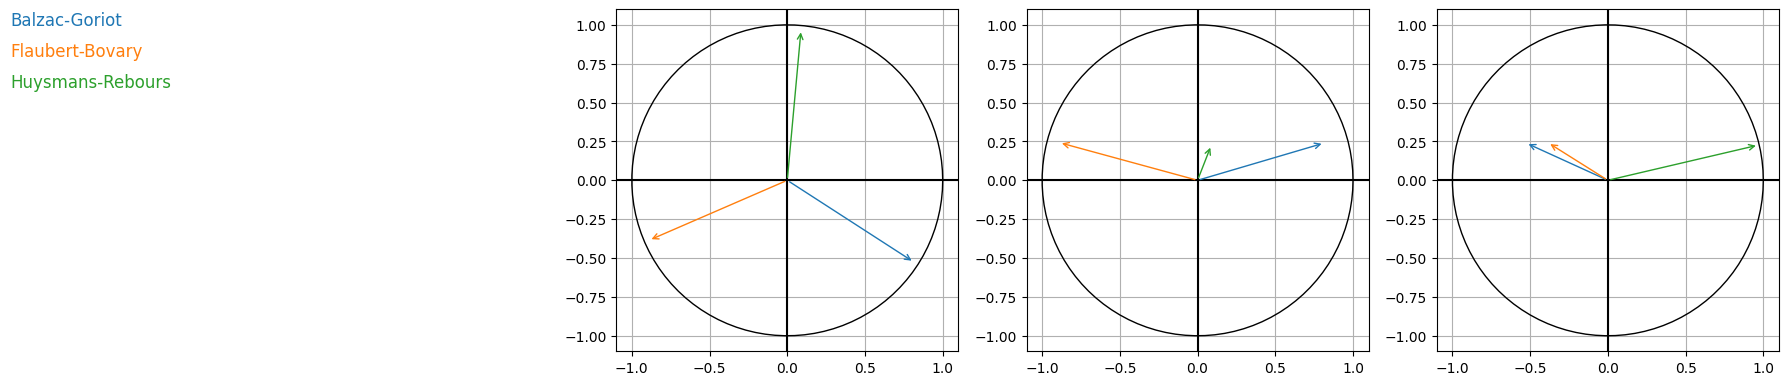

In [5]:
# Full pipeline

pipeline.execute("pca", plot=True, stat="proportion", n_tokens=15, plot_type="group")